#  Statistical Risk Model 실습

# 1. 데이터 준비

시가총액 상위 10개 종목으로 구성된 포트폴리오에 대해 Statistical Risk Model을 실습해보고 1년 모멘텀이라는 알파 팩터를 사용해 포트폴리오 최적화까지 진행해보겠습니다. 10개 종목의 5년치 종가 데이터를 받아옵니다.

In [1]:
from pykrx import stock
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import zscore

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10.0, 6.0]
%matplotlib inline

In [2]:
# 시가총액 상위 10개 종목의 5년치 종가 데이터를 구성하겠습니다
tickers = list(stock.get_market_cap_by_ticker("20210309",'KOSPI')['시가총액'].nlargest(10).index)
df = pd.DataFrame()

for stock_code in tickers:
    price = stock.get_market_ohlcv_by_date("20150101", "20210101", stock_code)['종가']
    df[stock_code] = price

log_price = np.log(df)

returns_df = (log_price-log_price.shift(1))[1:].fillna(0)

In [3]:
returns_df

,005930,000660,051910,005935,035420,005380,207940,006400,035720,068270
날짜,,,,,,,,,,
2015-01-05,0.002253,-0.002096,-0.031032,-0.004933,0.024325,-0.005935,0.000000,-0.017242,0.051840,-0.005135
2015-01-06,-0.028921,-0.003153,-0.049937,-0.005952,-0.008045,-0.021053,0.000000,-0.035402,0.005521,-0.018127
2015-01-07,0.009224,-0.002107,-0.009077,-0.003988,-0.014915,0.032888,0.000000,-0.004515,0.019762,-0.009203
2015-01-08,0.005341,0.052400,0.021053,0.020762,0.016258,0.045985,0.000000,0.031183,-0.006091,0.005277
2015-01-09,0.000000,-0.005018,0.060625,0.000978,0.010700,0.011173,0.000000,0.013072,0.014825,0.007864
...,...,...,...,...,...,...,...,...,...,...
2020-12-23,0.021889,0.030637,0.011229,0.020232,0.000000,0.005420,-0.008756,-0.001803,0.003981,-0.011205
2020-12-24,0.051429,0.017094,0.014779,0.040650,-0.007067,0.010753,-0.002516,0.016115,-0.009315,-0.021353
2020-12-28,0.011502,-0.021414,-0.004902,0.001373,-0.003552,0.013280,-0.006317,-0.007130,-0.002677,-0.041121


# 2. Statistical Risk Model 구축

PCA를 수행하는 fit_pca 함수를 정의했고 5개의 PC를 Risk Factor로 사용했습니다

In [4]:
from sklearn.decomposition import PCA

def fit_pca(returns, num_factor_exposures, svd_solver):
    
    pca = PCA(n_components=num_factor_exposures, svd_solver=svd_solver)
    pca.fit(returns)
    
    return pca

num_factor_exposures=5
svd_solver='full'

pca = fit_pca(returns_df, num_factor_exposures, svd_solver)

5개의 Risk Factor에 의해 설명되는 데이터의 분산 : 77.00673403010627%


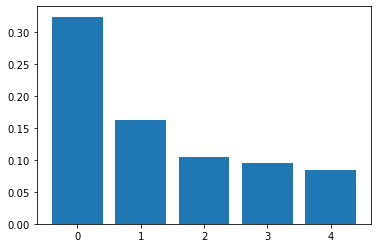

In [5]:
# 5개의 Risk Factor로 설명되는 원 데이터의 분산을 살펴봅시다
plt.bar(np.arange(num_factor_exposures), pca.explained_variance_ratio_);
print(f'{num_factor_exposures}개의 Risk Factor에 의해 설명되는 데이터의 분산 : {sum(pca.explained_variance_ratio_)*100}%')

## 2-1. B(Factor Exposure) 구하기

보기 쉽게 전부 데이터프레임 형식으로 만들어주겠습니다. index와 column은 아래와 같이 설정하시면 됩니다. 

데이터로 어떤 값이 들어가는지에 집중해주세요!

In [6]:
factor_beta = pd.DataFrame(pca.components_.T, index=returns_df.columns, columns=np.arange(num_factor_exposures))
factor_beta

,0,1,2,3,4
005930,0.238470,0.222449,0.309451,0.180372,-0.107779
000660,0.312981,0.235362,0.492455,0.247799,-0.042552
051910,0.378405,0.226635,-0.504460,0.066835,0.213057
005935,0.246382,0.226148,0.314449,0.195547,-0.113316
035420,0.218364,0.087094,0.202536,-0.570837,0.134135
005380,0.178838,0.121380,0.026871,0.014236,-0.128869
207940,0.302669,-0.292482,-0.193153,-0.125776,-0.862279
006400,0.426339,0.300630,-0.448573,0.123259,0.106185
035720,0.285238,0.007313,0.126287,-0.672699,0.128397
068270,0.454841,-0.770921,0.110245,0.231867,0.349935


## 2-2. f(Factor Return) 구하기

In [7]:
factor_return = pd.DataFrame(pca.transform(returns_df), index=returns_df.index, columns=np.arange(num_factor_exposures))
factor_return

,0,1,2,3,4
날짜,,,,,
2015-01-05,-0.006584,-0.007176,0.032339,-0.055451,0.001045
2015-01-06,-0.058389,-0.019311,0.025290,-0.018628,-0.014277
2015-01-07,-0.003583,0.007584,0.006600,-0.007388,-0.009592
2015-01-08,0.053630,0.035660,0.013808,0.019813,0.000154
2015-01-09,0.036467,0.013456,-0.033314,-0.009628,0.019254
...,...,...,...,...,...
2020-12-23,0.014775,0.030956,0.024560,0.011785,-0.000117
2020-12-24,0.024485,0.051082,0.018334,0.030113,-0.014654
2020-12-28,-0.031153,0.029819,-0.004808,-0.009033,-0.013564


## 2-3. s(Specific Return) 구하고 S 구하기

S = s의 분산의 대각행렬

전체 데이터에서 fB^T(Common Return)을 빼서 s를 구해줍니다.

In [8]:
common_returns = pd.DataFrame(np.dot(factor_return, factor_beta.T), index=returns_df.index, columns=returns_df.columns)
specific_returns = returns_df - common_returns

# diagonal을 취하는 이유 -> 행렬 계산을 위해
idiosyncratic_var_matrix = pd.DataFrame(np.diag(np.var(specific_returns)), index=returns_df.columns, columns=returns_df.columns)
idiosyncratic_var_matrix

,005930,000660,051910,005935,035420,005380,207940,006400,035720,068270
005930,0.000073,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
000660,0.000000,0.000135,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
051910,0.000000,0.000000,0.000134,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
005935,0.000000,0.000000,0.000000,0.000094,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
035420,0.000000,0.000000,0.000000,0.000000,0.000164,0.000000,0.000000,0.000000,0.000000,0.000000
005380,0.000000,0.000000,0.000000,0.000000,0.000000,0.000342,0.000000,0.000000,0.000000,0.000000
207940,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.000000,0.000000,0.000000
006400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000139,0.000000,0.000000
035720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000128,0.000000
068270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003


## 2-4. F(Factor Covariance) 구하기

In [9]:
factor_covariance_matrix = np.cov(factor_return.T)
factor_covariance_matrix

array([[ 1.71937966e-03,  4.50168397e-19,  4.33386449e-19,
         5.34666978e-19, -3.14146291e-19],
       [ 4.50168397e-19,  8.60830288e-04,  3.35638962e-19,
         6.10516967e-19,  1.30133703e-19],
       [ 4.33386449e-19,  3.35638962e-19,  5.54760259e-04,
        -3.72147059e-19, -2.82643336e-20],
       [ 5.34666978e-19,  6.10516967e-19, -3.72147059e-19,
         5.02147310e-04,  3.10907670e-19],
       [-3.14146291e-19,  1.30133703e-19, -2.82643336e-20,
         3.10907670e-19,  4.49131942e-04]])

## 2-5. 포트폴리오 공분산 계산하기

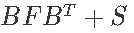

In [10]:
B = factor_beta
F = factor_covariance_matrix
S = idiosyncratic_var_matrix

print(f'B.shape : {B.shape}')
print(f'F.shape : {F.shape}')
print(f'B^T.shape : {B.T.shape}')
print(f'S^T.shape : {S.shape}')
print('===> 행렬 연산 가능한 형태 \n')

portfolio_covariance = B.dot(F).dot(B.T) + S

print(f'Portfolio Covariance.shape : {portfolio_covariance.shape}')

portfolio_covariance

B.shape : (10, 5)
F.shape : (5, 5)
B^T.shape : (5, 10)
S^T.shape : (10, 10)
===> 행렬 연산 가능한 형태 

Portfolio Covariance.shape : (10, 10)


,005930,000660,051910,005935,035420,005380,207940,006400,035720,068270
005930,0.000288,0.000282,0.000108,0.000222,0.000083,0.000109,0.000065,0.000161,0.000073,0.000062
000660,0.000282,0.000517,0.000116,0.000291,0.000117,0.000132,0.000052,0.000181,0.000103,0.000141
051910,0.000108,0.000116,0.000588,0.000112,0.000096,0.000121,0.000107,0.000476,0.000141,0.000156
005935,0.000222,0.000291,0.000112,0.000323,0.000082,0.000112,0.000069,0.000168,0.000072,0.000067
035420,0.000083,0.000117,0.000096,0.000082,0.000447,0.000067,0.000054,0.000103,0.000322,0.000080
005380,0.000109,0.000132,0.000121,0.000112,0.000067,0.000418,0.000109,0.000151,0.000078,0.000042
207940,0.000065,0.000052,0.000107,0.000069,0.000054,0.000109,0.000602,0.000145,0.000126,0.000269
006400,0.000161,0.000181,0.000476,0.000168,0.000103,0.000151,0.000145,0.000654,0.000144,0.000138
035720,0.000073,0.000103,0.000141,0.000072,0.000322,0.000078,0.000126,0.000144,0.000511,0.000168
068270,0.000062,0.000141,0.000156,0.000067,0.000080,0.000042,0.000269,0.000138,0.000168,0.000959


# 3. Portfolio Optimization

알파 팩터로 '1년 모멘텀'을 사용하겠습니다. 알파 팩터 검증 과정을 모두 거친 유효한 알파라고 가정합니다. 

알파 팩터 값 그대로 구성한 포트폴리오를 Theoretical Portfolio라 하고 우리는 이 가중치를 리스크를 고려하는 쪽으로 살짝 비틀어 '최적화된 가중치'를 얻고자 하는 것입니다.

알파 팩터가 유효하다고 검증된 이상 가장 최신 날짜의 '1년 모멘텀'을 알파 팩터로 사용하면 되고, 최적화 식은 다음과 같을 것입니다. 목적함수(Objective Function)가 생긴 모양을 잘 봐주세요!

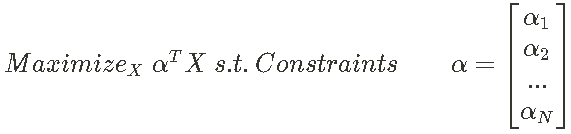

## 3-1. 알파 팩터 생성하기

In [11]:
# 1. log_price 결측치 'backfill' 방식으로 모두 채우기
# 실습의 편의를 위해서일뿐, 당연히 이렇게 간단하게 결측치를 처리하면 안됩니다.
log_price.fillna(method='backfill', inplace=True)

# 2. 일별 팩터 값 구하기
lookbackward_period = 252

momentum_df = (log_price.shift(1)-log_price.shift(1).shift(lookbackward_period)) * 100
momentum_df.dropna(how='all', inplace=True)

# 3. 가장 최신의 알파 팩터 값 사용
# rank 후 z-score
latest_alpha_factor = momentum_df.iloc[-1]
latest_alpha_factor.fillna(latest_alpha_factor.mean(), inplace=True)
latest_alpha_factor=pd.Series(data=zscore(latest_alpha_factor.rank()),index=latest_alpha_factor.index)

#4. latest_alpha_factor에 가중치 벡터 X를 곱해 포트폴리오 return을 변수로 만들어 Objective Function으로 쓸 것입니다
latest_alpha_factor

005930   -1.218544
000660   -1.566699
051910    1.218544
005935   -0.174078
035420   -0.522233
005380   -0.870388
207940    0.174078
006400    1.566699
035720    0.870388
068270    0.522233
dtype: float64

## 3-2. cvxpy를 이용한 포트폴리오 최적화

In [12]:
import cvxpy as cvx

# 5개의 주식으로 이루어진 포트폴리오 -> 5개의 원소로 이루어진 가중치 벡터 X
m = len(latest_alpha_factor)
X = cvx.Variable(m)

# 1. 포트폴리오 수익률 계산 (가중치 벡터 X에 따른 변수)
# cvxpy에 입력값을 넣을 때, index가 있으면 안되므로 array 형태로 바꿔줍니다
latest_alpha_factor_array = latest_alpha_factor.values

portfolio_return = latest_alpha_factor_array@X

# 2. 포트폴리오 리스크 계산 (가중치 벡터 X에 따른 변수)
portfolio_covariance = B.dot(F).dot(B.T) + S
portfolio_risk = cvx.quad_form(X, portfolio_covariance)
annualized_portfolio_risk = portfolio_risk * np.sqrt(252)

# 3. Objective Function & Constraints 정의
# Constraints로는 레버리지 비율 1 이하
objective = cvx.Maximize(portfolio_return)

constraints = [sum(cvx.abs(X)) <= 1.0]

problem = cvx.Problem(objective,constraints)
print(f'이 최적화 식은 convex 형태인가? : {problem.is_dcp()}')

result = problem.solve()

optimal_weights = np.asarray(X.value).flatten()

print('\n최적화 완료')

이 최적화 식은 convex 형태인가? : True

최적화 완료


In [13]:
# 최적화 결과 006400(삼성SDI)에 0.5의 비율로 Long Position, 000660(SK하이닉스)에 0.5의 비율로 Short Position을 취한 것을 볼 수 있다
# 나머지 주식은 거의 0의 가중치를 가짐
pd.DataFrame(data=optimal_weights, index=latest_alpha_factor.index).nlargest(10, columns=0)

,0
006400,5.000000e-01
035720,6.079593e-11
068270,4.982436e-11
207940,1.610490e-11
051910,1.400879e-11
005930,-1.400879e-11
005935,-1.610490e-11
035420,-4.982436e-11
005380,-6.079593e-11
000660,-5.000000e-01
